In [1]:
from utils.experiment_utils import get_all_experiments_info, load_best_model
import torch
import os
import hydra
from omegaconf import DictConfig, OmegaConf


import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def spearmanr(x, y):
    rx = x.argsort().argsort()
    ry = y.argsort().argsort()
    return torch.corrcoef(torch.stack([rx.float(), ry.float()]))[0, 1]

In [3]:
def dists_and_errors(cfg, num_samples=1000, return_xy=False):

    # build models + dataset
    encoder_cfg = cfg['config']['encoder']
    generator_cfg = cfg['config']['generator']
    dataset_cfg = cfg['config']['dataset']
    
    encoder = hydra.utils.instantiate(encoder_cfg)
    generator = hydra.utils.instantiate(generator_cfg)
    dataset = hydra.utils.instantiate(dataset_cfg)

    # load model weights

    if not os.path.exists(cfg['dir']+'/best_model.pt'):
        print('No best model file...')
        return "No best model file..."
    
    best_model = load_best_model(cfg['dir'])
    encoder.load_state_dict(best_model['encoder_state_dict'])
    generator.model.load_state_dict(best_model['generator_state_dict'])

    with torch.no_grad():
        # grab data + encode
        x = torch.tensor(dataset.data[:num_samples], dtype=torch.float32)
        z = encoder(x)

        # fisher rao + L2 distances
        # fr = torch.tensor(dataset.fisher_rao_distance(dataset.mu[:num_samples],
        #                                               dataset.var[:num_samples]))
        fr = torch.tensor(dataset.fisher_rao_distance(dataset.probs[:num_samples]))

        zl2 = torch.cdist(z, z, p=1)

        # just upper triangle
        fr_vals = fr.triu(1)[fr.triu(1) != 0]
        l2_vals = zl2.triu(1)[zl2.triu(1) != 0]
        xy = torch.stack([fr_vals, l2_vals], dim=1)

        # # generate + compare stats
        # samples = generator.sample(z, num_samples)
        # mean_mse = ((samples.mean(dim=1) - dataset.mu[:num_samples])**2).mean().item()
        # var_mse = ((samples.var(dim=1) - dataset.var[:num_samples])**2).mean().item()

        # compute rank corr
        spearman_r = spearmanr(xy[:, 0], xy[:, 1]).item()

    # say hi
    print(cfg['encoder'])
    print(cfg['generator'])
    print('spearman r:', spearman_r)
    # print('mean mse:', mean_mse)
    # print('var mse:', var_mse)

    return {
        'encoder': cfg['encoder'],
        'generator': cfg['generator'],
        'spearman_r': spearman_r,
        # 'mean_mse': mean_mse,
        # 'var_mse': var_mse,
        'xy': xy if return_xy else None,
    }


In [ ]:
# base_dir = 'outputs/'
# configs = get_all_experiments_info(base_dir, False)
# simple_configs = [c  for c in configs if 'simple' in c['name']]


# fig, axs = plt.subplots(2, 4, figsize=(10, 4), dpi=200)

# for c in simple_configs:
#     if c['config']['training']['num_epochs'] > 20:

#         N_dims = c['config']['dataset']['data_shape'][0]
#         print('N_dims:', N_dims)

#         d = dists_and_errors(c, num_samples=200, return_xy=True)
        
#         x, y = d['xy'][:, 0], d['xy'][:, 1]


#         i = 'GNN' in d['encoder']
#         j = N_dims - 2

#         ax = axs.flatten()[i * 4 + j]

#         print(i*4+j)

#         sns.kdeplot(x=x, y=y, levels=10, ax=ax, cmap='Blues', 
#                     fill=True, thresh=0.05)
#         ax.set_xlabel('Fisher Rao Distance')
#         ax.set_ylabel('Latent L2 Distance')
#         # ax.set_title(d['encoder']+'+'+d['generator']+', '+str(N_dims)+'dims')

# plt.show()

In [4]:
base_dir = 'outputs/'
configs = get_all_experiments_info(base_dir, False)
multi = [c  for c in configs if 'spike' in c['name']]

In [15]:
spike1 = [c for c in configs if 'multinomial' in c['name'] and 'spike' not in c['name']]
spike1 = [c for c in spike1 if c['config']['dataset']['data_shape'][0] == 2]
dataset_cfg = spike1[0]['config']['dataset']

spike1

[{'name': 'multinomial_56d7e399cfbda17fcff38dc7853db86e',
  'dir': 'outputs/multinomial_56d7e399cfbda17fcff38dc7853db86e',
  'config': {'dataset': {'_target_': 'datasets.distribution_datasets.MultinomialDistributionDataset', 'n_sets': 10000, 'set_size': 100, 'n_per_multinomial': 20, 'seed': '${seed}', 'data_shape': [2]}, 'encoder': {'_target_': 'encoder.encoders.DistributionEncoderTx', 'in_dim': '${dataset.data_shape[0]}', 'latent_dim': '${experiment.latent_dim}', 'hidden_dim': '${experiment.hidden_dim}', 'set_size': '${experiment.set_size}', 'layers': 2, 'heads': 4}, 'model': {'_target_': 'layers.MLP', 'in_dims': [2, 16, 1], 'hidden_dim': 64, 'out_dim': 2, 'layers': 4}, 'generator': {'_target_': 'generator.ddpm.DDPM', 'model': '${model}', 'betas': [0.0001, 0.02], 'n_T': 400, 'drop_prob': 0.1, 'noise_shape': '${dataset.data_shape}'}, 'optimizer': {'_target_': 'torch.optim.Adam', '_partial_': True, 'lr': '${experiment.lr}', 'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0}, 'sched

In [16]:
cfg = multi[1]
num_samples = 200

# build models + dataset
encoder_cfg = cfg['config']['encoder']
generator_cfg = cfg['config']['generator']


print(cfg['config']['dataset']['spike'])

encoder = hydra.utils.instantiate(encoder_cfg)
generator = hydra.utils.instantiate(generator_cfg)
dataset = hydra.utils.instantiate(dataset_cfg)

# load model weights

if not os.path.exists(cfg['dir']+'/best_model.pt'):
    print('No best model file...')

best_model = load_best_model(cfg['dir'])
encoder.load_state_dict(best_model['encoder_state_dict'])
generator.model.load_state_dict(best_model['generator_state_dict'])

with torch.no_grad():
    # grab data + encode
    x = torch.tensor(dataset.data[:num_samples], dtype=torch.float32)
    z = encoder(x)

    # fisher rao + L2 distances
    fr = torch.tensor(dataset.fisher_rao_distance(dataset.probs[:num_samples]))
    zl2 = torch.cdist(z, z, p=1)
    print(spearmanr(fr.flatten(), zl2.flatten()).item())

10
0.9759538173675537


/orcd/data/omarabu/001/gokul/DistributionEmbeddings/datasets/distribution_datasets.py:191: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(np.sqrt(probs[:, None, :] * probs[None, :, :]).sum(axis=2))


/tmp/ipykernel_2118934/2883602857.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=fr.flatten(),


Text(0, 0.5, 'Latent L2 Distance')

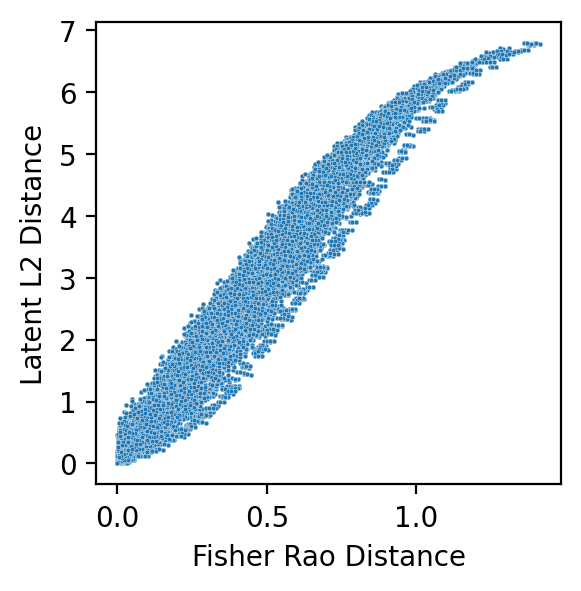

In [19]:
fig = plt.figure(figsize=(3,3), dpi=200)
sns.scatterplot(x=fr.flatten(),
            y=zl2.flatten(),
            palette='mako', s=3, hue_norm=(0, 20))
plt.xlabel('Fisher Rao Distance')
plt.ylabel('Latent L2 Distance')

N_dims: 5


/orcd/data/omarabu/001/gokul/DistributionEmbeddings/datasets/distribution_datasets.py:189: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(np.sqrt(probs[:, None, :] * probs[None, :, :]).sum(axis=2))
/orcd/data/omarabu/001/gokul/DistributionEmbeddings/datasets/distribution_datasets.py:189: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(np.sqrt(probs[:, None, :] * probs[None, :, :]).sum(axis=2))


DistributionEncoderTx
DDPM
spearman r: 0.9476807713508606
N_dims: 2
DistributionEncoderTx
DDPM
spearman r: 0.9886742234230042
N_dims: 3


/orcd/data/omarabu/001/gokul/DistributionEmbeddings/datasets/distribution_datasets.py:189: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(np.sqrt(probs[:, None, :] * probs[None, :, :]).sum(axis=2))


DistributionEncoderTx
DDPM
spearman r: 0.9886652231216431
N_dims: 4
DistributionEncoderTx
DDPM
spearman r: 0.969834566116333


/orcd/data/omarabu/001/gokul/DistributionEmbeddings/datasets/distribution_datasets.py:189: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(np.sqrt(probs[:, None, :] * probs[None, :, :]).sum(axis=2))


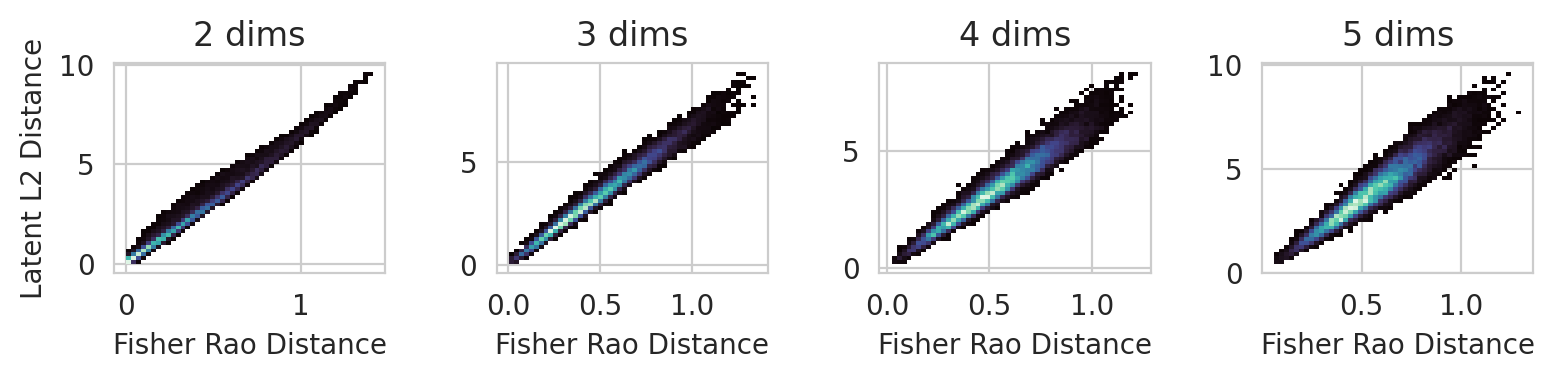

In [24]:
sns.set_style('whitegrid')
fig, axs = plt.subplots(1, 4, figsize=(8, 2), dpi=200)

for c in multi:
    if c['config']['training']['num_epochs'] > 20:

        N_dims = c['config']['dataset']['data_shape'][0]
        print('N_dims:', N_dims)

        d = dists_and_errors(c, num_samples=200, return_xy=True)
        
        x, y = d['xy'][:, 0], d['xy'][:, 1]

        j = N_dims - 2

        ax = axs.flatten()[j]

        # sns.scatterplot(x=x, y=y, s=1, color="k", alpha=0.3, ax=ax)
        sns.histplot(x=x, y=y, bins=50, cmap="mako", ax=ax)
        # sns.kdeplot(x=x, y=y, levels=5, color="yellow", linewidths=1, ax=ax)

        # sns.kdeplot(x=x, y=y, levels=10, ax=ax, cmap='mako', 
        #             fill=True, thresh=0.05)
        ax.set_xlabel('Fisher Rao Distance')
        if j == 0:
            ax.set_ylabel('Latent L2 Distance')
        else:
            ax.set_ylabel('')
        ax.set_title(str(N_dims)+' dims')

plt.tight_layout()
plt.show()